# CAB420, Week 5 Practical, Question 1 Solution
## Fine-Tuning DCNNs. 
The Kuzushiji-MNIST-49 database, or K-MNIST-49, is a MNIST like database, though with a substantially larger number of classes. However while the number of classes and the variety within them is increased over MNIST, the characteristics of the images are largely the same, i.e. the database is made up of 28x28 pixel grey scale images, where pixel values are often close to 0 or 1 (i.e. black or white). Given this, a model trained on MNIST is likely to adapt well when fine-tuned on K-MNIST-49.

Using a model that has been trained on MNIST and the K-MNIST-49 dataset:
* Modify the network to classify 49 classes rather than the original 10;
* Fine-tune the network and assess the model’s performance. Consider how it compares to the models trained from scratch in the Week 4 practical.

In [1]:
import os
# why is this here? This is disabling some tensorflow warning I get in some of my environments that 
# annoy me (look ugly and untidy really)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
# function to compute class weights
from sklearn.utils import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.io
import numpy

## The Data
As per last week, we'll use scipy.io.loadmat to get the data in.

We'll do the required reshape to get it into the format that keras wants, and then print a bit for a sanity check.

Note that as per the addendum to last weeks solution, we're going to use to_categorical to get the data into a one-hot vector form.

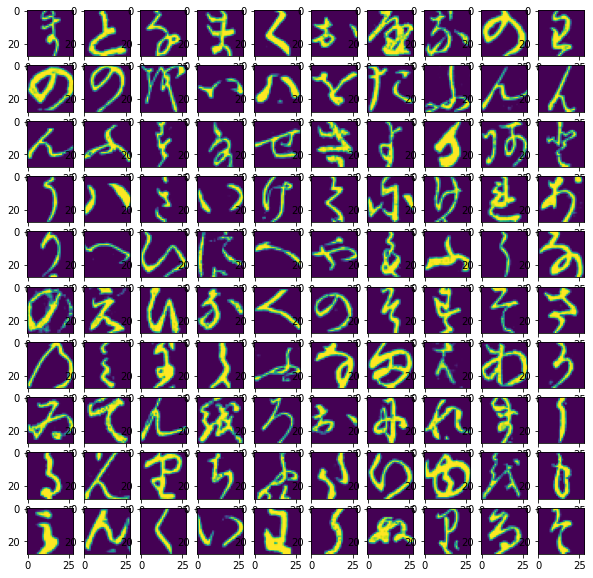

In [2]:
kmnist_train = scipy.io.loadmat('../../data/kmnist/kmnist49_train.mat')
kmnist_test = scipy.io.loadmat('../../data/kmnist/kmnist49_test.mat')
train = numpy.transpose(kmnist_train['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
train_y = to_categorical(kmnist_train['labels'], 49)
test = numpy.transpose(kmnist_test['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
test_y = to_categorical(kmnist_test['labels'], 49)

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(train[i,:,:,0])

## Fine Tuning

For completeness, and because it's easy, we'll tune a couple of different models. 

### Model 1

We'll start with a simple VGG model.

In [3]:
model = keras.models.load_model('../../trained_models_keras/vgg_2stage_MNIST_small.h5')
model.summary()

Model: "simple_vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 8)         80        
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 8)         584       
_________________________________________________________________
batch_normalization_17 (Batc (None, 28, 28, 8)         32        
_________________________________________________________________
activation_17 (Activation)   (None, 28, 28, 8)         0         
_________________________________________________________________
spatial_dropout2d_10 (Spatia (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 8)         0

And swap out the last layer for a brand new dense layer, with 49 outputs (as we have 49 classes).

In [4]:
outputs = layers.Dense(49, activation='softmax')(model.layers[-2].output)
new_model = keras.Model(inputs=model.input, outputs=outputs)
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 8)         80        
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 8)         584       
_________________________________________________________________
batch_normalization_17 (Batc (None, 28, 28, 8)         32        
_________________________________________________________________
activation_17 (Activation)   (None, 28, 28, 8)         0         
_________________________________________________________________
spatial_dropout2d_10 (Spatia (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 8)         0     

We'll then lock off all the convolution layers, and tune just the Dense layers (the new one, and the one that was already there)

In [5]:
for layer in new_model.layers[:-5]:
    layer.trainable = False

for layer in new_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f56da5a5d30> False
<keras.layers.convolutional.Conv2D object at 0x7f574c8d4190> False
<keras.layers.convolutional.Conv2D object at 0x7f56d8ceb520> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f56d8ceba30> False
<keras.layers.core.Activation object at 0x7f56d8cebb50> False
<keras.layers.core.SpatialDropout2D object at 0x7f56d8cebf70> False
<keras.layers.pooling.MaxPooling2D object at 0x7f56d8481220> False
<keras.layers.convolutional.Conv2D object at 0x7f56d8481580> False
<keras.layers.convolutional.Conv2D object at 0x7f56d8481a00> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f56d8481f10> False
<keras.layers.core.Activation object at 0x7f56d8482070> False
<keras.layers.core.SpatialDropout2D object at 0x7f56d8482490> False
<keras.layers.core.Flatten object at 0x7f56d84824f0> False
<keras.layers.core.Dense object at 0x7f56d8482970> True
<keras.layers.normaliza

Now for training.

In [6]:
new_model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])
history = new_model.fit(train, train_y,
                        batch_size=128,
                        epochs=10,
                        validation_data=(test, test_y))

Epoch 1/10
1816/1816 [==============================] - 41s 20ms/step - loss: 2.5235 - accuracy: 0.3979 - val_loss: 2.1760 - val_accuracy: 0.4926
Epoch 2/10
1816/1816 [==============================] - 35s 20ms/step - loss: 1.7205 - accuracy: 0.5845 - val_loss: 1.8588 - val_accuracy: 0.5567
Epoch 3/10
1816/1816 [==============================] - 36s 20ms/step - loss: 1.4766 - accuracy: 0.6371 - val_loss: 1.6757 - val_accuracy: 0.5962
Epoch 4/10
1816/1816 [==============================] - 36s 20ms/step - loss: 1.3309 - accuracy: 0.6691 - val_loss: 1.5475 - val_accuracy: 0.6249
Epoch 5/10
1816/1816 [==============================] - 36s 20ms/step - loss: 1.2240 - accuracy: 0.6930 - val_loss: 1.4532 - val_accuracy: 0.6450
Epoch 6/10
1816/1816 [==============================] - 36s 20ms/step - loss: 1.1475 - accuracy: 0.7107 - val_loss: 1.3740 - val_accuracy: 0.6609
Epoch 7/10
1816/1816 [==============================] - 36s 20ms/step - loss: 1.0838 - accuracy: 0.7247 - val_loss: 1.3108 -

In [7]:
def eval_model(model, history, x_train, y_train, x_test, y_test):

    fig = plt.figure(figsize=[20, 20])    

    ax = fig.add_subplot(1, 1, 1)    
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(y_test, axis=1)

    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx, xticklabels=range(49), yticklabels=range(49), 
            annot=True, fmt='g', ax=ax)

    fig = plt.figure(figsize=[10, 5])    

    ax = fig.add_subplot(1, 1, 1)    
    ax.plot(history['loss'], label='Loss')
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.plot(history['accuracy'], label='Accuracy')
    ax.plot(history['val_accuracy'], label='Validation Accuracy')
    ax.legend()

    print(classification_report(gt_idx, indexes))

We can see performance looks ok.

              precision    recall  f1-score   support

           0       0.72      0.83      0.77      1000
           1       0.85      0.85      0.85      1000
           2       0.73      0.93      0.81      1000
           3       0.60      0.47      0.53       126
           4       0.79      0.73      0.76      1000
           5       0.69      0.58      0.63      1000
           6       0.71      0.71      0.71      1000
           7       0.76      0.80      0.78      1000
           8       0.50      0.56      0.53       767
           9       0.74      0.70      0.72      1000
          10       0.88      0.66      0.76      1000
          11       0.75      0.75      0.75      1000
          12       0.53      0.66      0.59      1000
          13       0.71      0.61      0.65       678
          14       0.56      0.53      0.54       629
          15       0.68      0.66      0.67      1000
          16       0.69      0.84      0.76       418
          17       0.64    

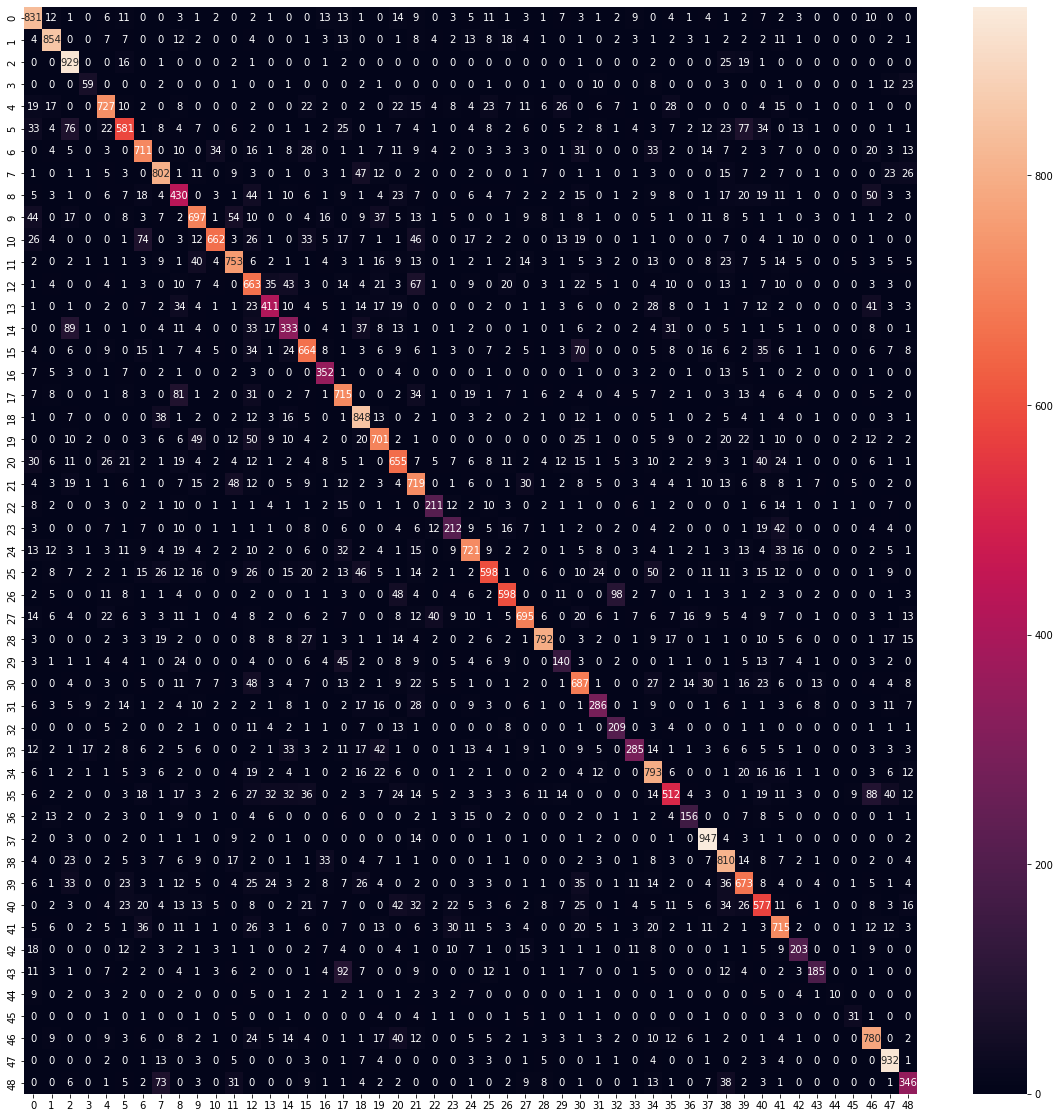

<Figure size 720x576 with 0 Axes>

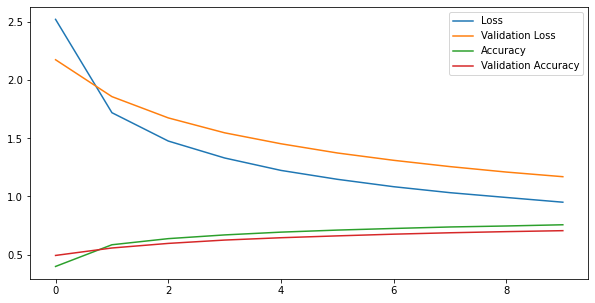

In [8]:
eval_model(new_model, history.history, train, train_y, test, test_y)

### Model 2 - A ResNet
We'll tune up a different model now. This time a simple ResNet. We'll follow the same process as the first time around. However this time we'll tune just the last layer as that is the only dense layer in the network.

In [9]:
model = keras.models.load_model('../../trained_models_keras/resnet_v1_MNIST_medium.h5')
model.summary()

Model: "medium_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 28, 28, 8)    80          img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 28, 28, 8)    32          conv2d_109[0][0]                 
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 28, 28, 8)    0           batch_normalization_95[0][0]     
___________________________________________________________________________________

In [10]:
outputs = layers.Dense(49, activation='softmax')(model.layers[-2].output)
new_model = keras.Model(inputs=model.input, outputs=outputs)
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 28, 28, 8)    80          img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 28, 28, 8)    32          conv2d_109[0][0]                 
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 28, 28, 8)    0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

In [11]:
# Freeze the layers except the last 1 layers
for layer in new_model.layers[:-1]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in new_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f56280bab80> False
<keras.layers.convolutional.Conv2D object at 0x7f56280bad30> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f56280ba8b0> False
<keras.layers.core.Activation object at 0x7f56280c1430> False
<keras.layers.convolutional.Conv2D object at 0x7f56280c1850> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f56280c1f10> False
<keras.layers.core.Activation object at 0x7f56280c1fd0> False
<keras.layers.convolutional.Conv2D object at 0x7f56280c1fa0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f56281bbaf0> False
<keras.layers.merge.Add object at 0x7f56281bbf70> False
<keras.layers.core.Activation object at 0x7f56281bfa30> False
<keras.layers.convolutional.Conv2D object at 0x7f56281bbfa0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f56281bf910> False
<keras.layers.core.Activa

In [12]:
new_model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])
history = new_model.fit(train, train_y,
                        batch_size=128,
                        epochs=10,
                        validation_data=(test, test_y))

Epoch 1/10
1816/1816 [==============================] - 50s 27ms/step - loss: 3.2105 - accuracy: 0.2170 - val_loss: 3.0964 - val_accuracy: 0.2555
Epoch 2/10
1816/1816 [==============================] - 48s 27ms/step - loss: 2.6278 - accuracy: 0.3676 - val_loss: 2.9427 - val_accuracy: 0.3005
Epoch 3/10
1816/1816 [==============================] - 46s 25ms/step - loss: 2.4636 - accuracy: 0.4030 - val_loss: 2.8787 - val_accuracy: 0.3144
Epoch 4/10
1816/1816 [==============================] - 46s 26ms/step - loss: 2.3773 - accuracy: 0.4200 - val_loss: 2.8359 - val_accuracy: 0.3261
Epoch 5/10
1816/1816 [==============================] - 46s 25ms/step - loss: 2.3209 - accuracy: 0.4311 - val_loss: 2.8084 - val_accuracy: 0.3350
Epoch 6/10
1816/1816 [==============================] - 46s 25ms/step - loss: 2.2790 - accuracy: 0.4404 - val_loss: 2.7798 - val_accuracy: 0.3415
Epoch 7/10
1816/1816 [==============================] - 47s 26ms/step - loss: 2.2453 - accuracy: 0.4479 - val_loss: 2.7632 -

/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00       126
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.01      0.14      0.03      1000
           7       0.04      0.35      0.07      1000
           8       0.00      0.00      0.00       767
           9       0.00      0.00      0.00      1000
          10       0.00      0.00      0.00      1000
          11       0.00      0.00      0.00      1000
          12       0.00      0.00      0.00      1000
          13       0.00      0.00      0.00       678
          14       0.00      0.00      0.00       629
          15       0.00      0.00      0.00      1000
          16       0.00      0.00      0.00       418
          17       0.00    

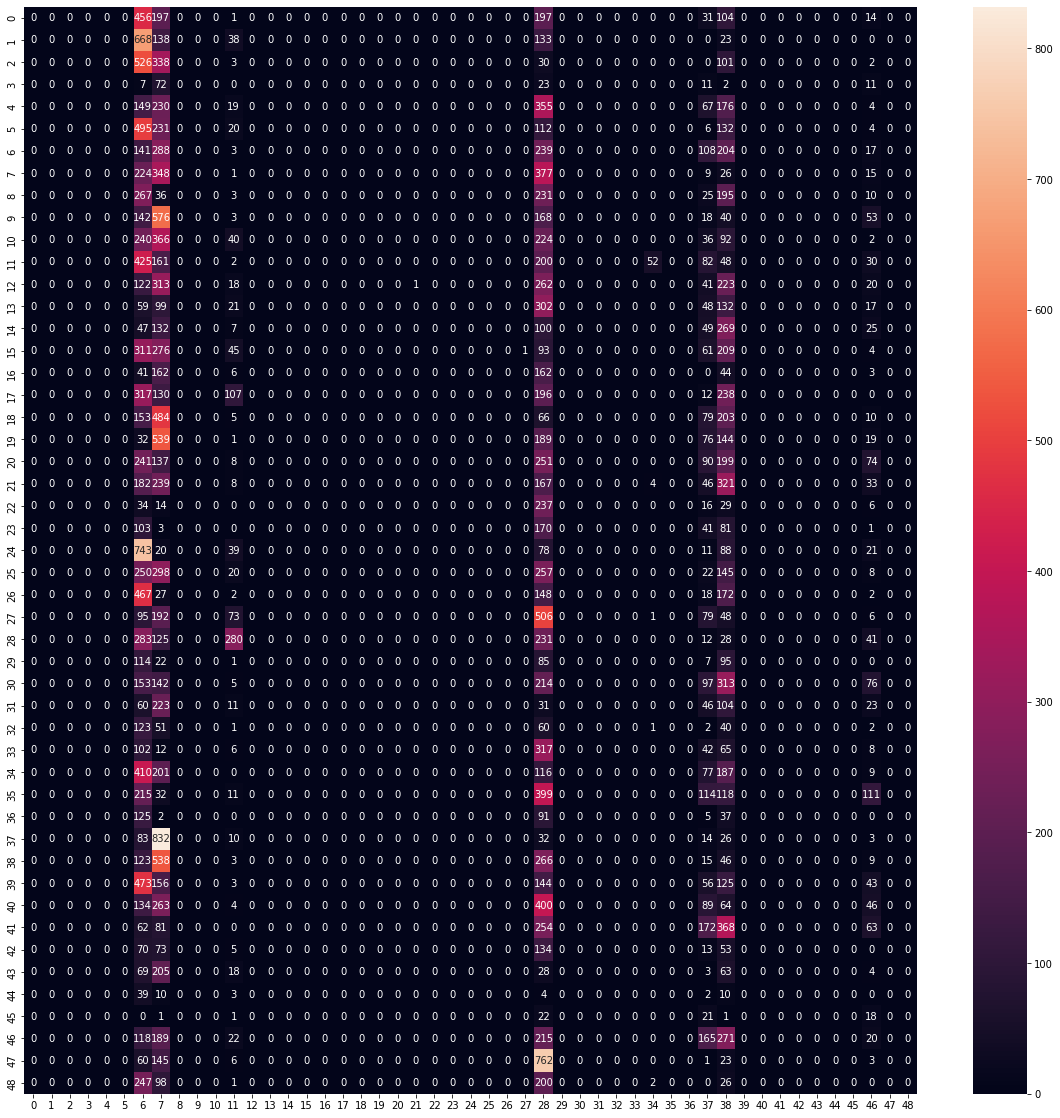

<Figure size 720x576 with 0 Axes>

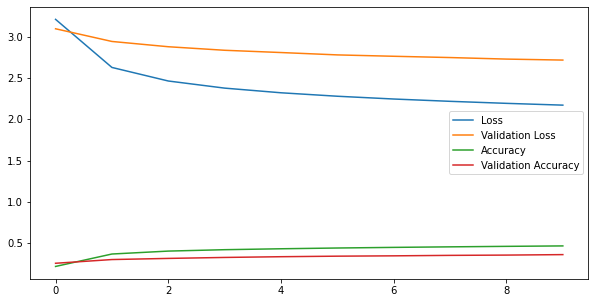

In [17]:
eval_model(new_model, history.history, train, train_y, test, test_y)

### Model 2A - The Same Resnet Again

For our ResNet, before we only tuned one layer. Let's tune the lot this time and see what happens. This will be the same as last time, we'll just leave out the bit where we freeze layer weights.

In [18]:
model = keras.models.load_model('../../trained_models_keras/resnet_v1_MNIST_medium.h5')
model.summary()

Model: "medium_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 28, 28, 8)    80          img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 28, 28, 8)    32          conv2d_109[0][0]                 
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 28, 28, 8)    0           batch_normalization_95[0][0]     
___________________________________________________________________________________

In [19]:
outputs = layers.Dense(49, activation='softmax')(model.layers[-2].output)
new_model = keras.Model(inputs=model.input, outputs=outputs)
new_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 28, 28, 8)    80          img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 28, 28, 8)    32          conv2d_109[0][0]                 
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 28, 28, 8)    0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

This time we'll tune the whole network.

In [20]:
new_model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])
history = new_model.fit(train, train_y,
                        batch_size=128,
                        epochs=10,
                        validation_data=(test, test_y))

Epoch 1/10
1816/1816 [==============================] - 86s 46ms/step - loss: 2.2706 - accuracy: 0.4837 - val_loss: 2.0564 - val_accuracy: 0.5148
Epoch 2/10
1816/1816 [==============================] - 101s 56ms/step - loss: 1.1408 - accuracy: 0.7361 - val_loss: 1.5677 - val_accuracy: 0.6285
Epoch 3/10
1816/1816 [==============================] - 97s 53ms/step - loss: 0.7906 - accuracy: 0.8193 - val_loss: 1.2361 - val_accuracy: 0.7039
Epoch 4/10
1816/1816 [==============================] - 88s 49ms/step - loss: 0.6199 - accuracy: 0.8572 - val_loss: 1.0354 - val_accuracy: 0.7508
Epoch 5/10
1816/1816 [==============================] - 89s 49ms/step - loss: 0.5208 - accuracy: 0.8787 - val_loss: 0.9507 - val_accuracy: 0.7636
Epoch 6/10
1816/1816 [==============================] - 90s 50ms/step - loss: 0.4542 - accuracy: 0.8938 - val_loss: 0.8210 - val_accuracy: 0.7930
Epoch 7/10
1816/1816 [==============================] - 97s 54ms/step - loss: 0.4069 - accuracy: 0.9046 - val_loss: 0.8215 

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1000
           1       1.00      0.80      0.88      1000
           2       0.81      0.97      0.88      1000
           3       0.93      0.60      0.72       126
           4       0.94      0.66      0.78      1000
           5       0.83      0.72      0.77      1000
           6       0.95      0.68      0.80      1000
           7       0.81      0.89      0.85      1000
           8       0.53      0.83      0.65       767
           9       0.95      0.70      0.81      1000
          10       0.97      0.70      0.81      1000
          11       0.95      0.76      0.84      1000
          12       0.73      0.82      0.78      1000
          13       0.59      0.74      0.66       678
          14       0.66      0.66      0.66       629
          15       0.92      0.78      0.85      1000
          16       0.99      0.82      0.90       418
          17       0.84    

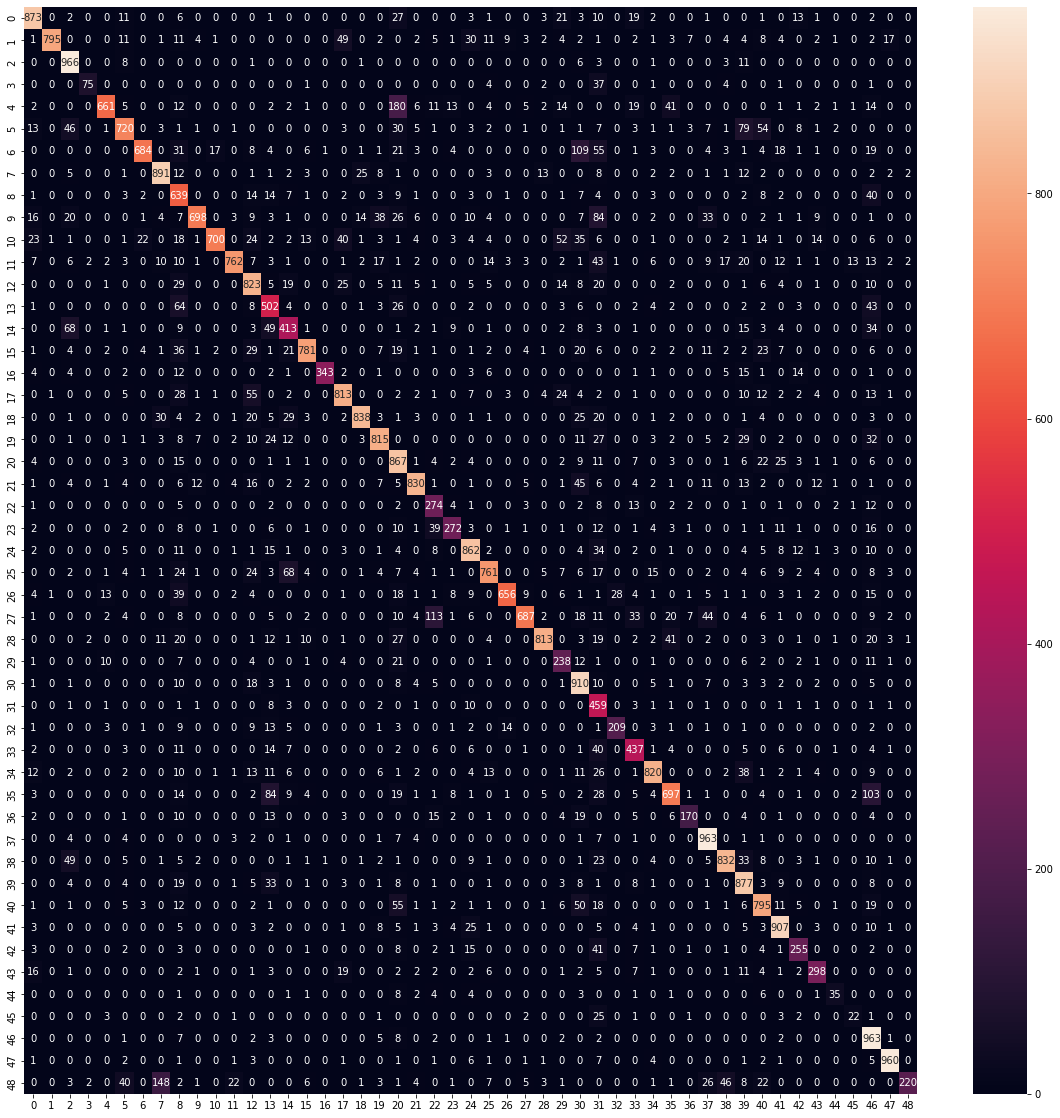

<Figure size 720x576 with 0 Axes>

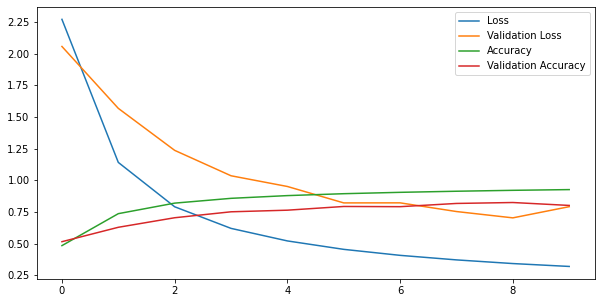

In [21]:
eval_model(new_model, history.history, train, train_y, test, test_y)

## Final Thoughts

We see good results from the fine-tuning, but one point is worth consideration: our first attempt at ResNet is nowhere near as good as our second. Why?

This really comes down to our last couple of layers, which are:
* An average pooling of the final convolution filters
* A dense layer to get the output

In our VGG networks we have 2 (or more) dense layers to learn our how to map the convolutional features to the output. With ResNet, we don't. As such, merely replacing the last layer and training only that doesn't work that well. If we had an extra dense layer in there, or allowed all of the last Residual block to be trained (or just fine-tune the lot), we do a lot better.